# Let us Fix the Mistake we made in last notebook
We did a Serious Mistake in Part-5 Notebook. It is regarding the choice of baseline.
If you have not spot it yet then I encourage you to study the derivation given in the Box 
titled __The Bandit Gradient Algorithm as Stochastic Gradient Ascent.__ In this, the author
has mentioned it clearly that **Baseline can be any scalar that does not depend on x where
x is a value of RV $A_t$.** We have clearly violated that condition ($R_{avg}(a)$ depends on action a) .
In this notebook, we will calculate our baseline as average reward of pervious steps(t) rather
than actions(a).

## Revisit the equations
In this section we consider learning a numerical preference for each action
$a$, which we denote $H_t (a)$. The larger the preference, the more often that action is taken,
but the preference has no interpretation in terms of reward. Only the relative preference
of one action over another is important;

\begin{equation*}
\Pr  \{ A_t = a \} \approx \frac { \exp^{H_t(a)} } { \sum_{b=1}^k \exp^{H_t(b)}} \approx \pi_t(a)
\end{equation*}

where \begin{align*} \pi_t(a) \end{align*} is the probability of taking action a at time t and


$H_1$(a) = 0 for all a

There is a natural learning algorithm for this setting based on the idea of stochastic
gradient ascent. On each step, after selecting action $A_t$ and receiving the reward  $R_t$ , the
action preferences are updated by :


\begin{equation*}
H_{t+1}(A_t)  = H_t(A_t) + \alpha  (R_t - \overline{R_t}) ( 1 - \pi_t(A_t)) \space  and  \\
H_{t+1}(a)  = H_t(a) + \alpha  (R_t - \overline{R_t}) ( \pi_t(a))\space \forall a \ne A_t
\end{equation*}

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import __version__ as matplotlib_version

In [2]:
print("numpy version - ", np.__version__)
print("matplotlib version - ", matplotlib_version)

numpy version -  1.17.4
matplotlib version -  3.2.1


In [3]:
import multiprocessing

In [4]:
def softmax_distribution(preference_estimates):
    maxval = np.amax(preference_estimates)
    exps = np.exp(preference_estimates - maxval) # Using Property of Softmax function
    
    return  exps / np.sum( exps,axis=0 )

def gradient_bandit(steps, n_bandit, n_lever, step_size,is_baseline_applied,
          testbed, initial_reward_estimates, global_reward_list):
    
    action_count = np.ones((n_bandit,n_lever))  # each lever is pulled atleast once
    Ravg = np.zeros((n_bandit,n_lever))  # avg_reward_estimates
    Hpref = np.zeros((n_bandit, n_lever)) # preference_estimates
    pr_a_t = np.zeros((n_bandit, n_lever)) # probability of action a at time t

    
    optimal_choice_per_step = []
    mean_reward = 0
    
    for step in range(0,steps):
        sum_of_optimal_choice = 0 
        for b in range(n_bandit):  
            
            pr_a_t[b] = softmax_distribution(Hpref[b])
            A = np.random.choice(np.arange(n_lever), p = pr_a_t[b])
            
            if A == np.argmax(testbed[b]):
                sum_of_optimal_choice += 1 
            
            Rn = np.random.normal(testbed[b][A],1)
            
            if is_baseline_applied == True:
                n = step+1
                mean_reward = ( Rn + (n - 1) * mean_reward ) / n
            
            
            Hpref[b][:A] = Hpref[b][:A] - (step_size * (Rn -mean_reward) * pr_a_t[b][:A])
            Hpref[b][A+1:] = Hpref[b][A+1:] - (step_size * (Rn - mean_reward) * pr_a_t[b][A+1:])
            
            Hpref[b][A] = Hpref [b][A] +  (step_size * (Rn - mean_reward)  * (1 - pr_a_t [b][A] ))                         
        optimal_choice_per_step.append((sum_of_optimal_choice/n_bandit)*100)
    global_reward_list.append(optimal_choice_per_step)
    return 

In [5]:
### With baseline and without baseline

In [6]:
# Produce a testbed of 2000 bandit problems
np.random.seed(10)
n_bandit = 2000
n_lever = 10
steps = 1000

# Setting mean of true reward to +4 rather than near zero. This
# shifting up of all the rewards has absolutely no e↵ect on the gradient bandit algorithm
# because of the reward baseline term, which instantaneously adapts to the new level.

testbed = np.random.normal(4,1,(n_bandit,n_lever))
initial_reward_estimates =  np.random.normal(testbed,1)

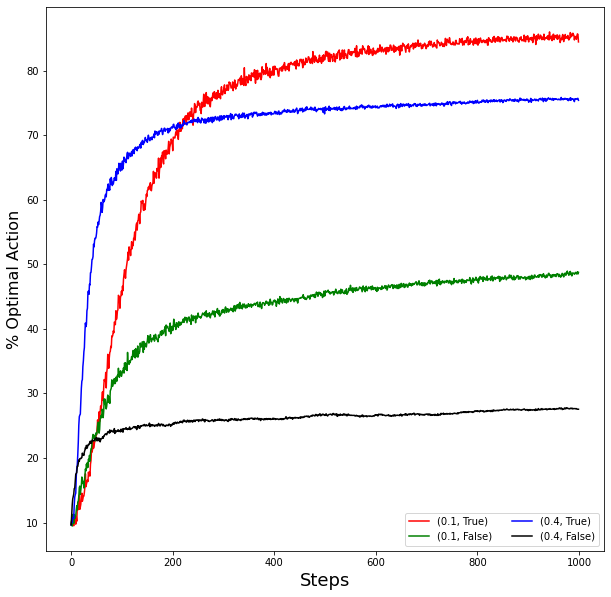

CPU times: user 149 ms, sys: 18.4 ms, total: 168 ms
Wall time: 2min 46s


In [7]:
%%time
with multiprocessing.Manager() as manager:
    global_reward_list = []
    mp_objects = []
    apply_baseline = [True, False,True,False] 
    stepSize_list    = [0.1, 0.1, 0.4, 0.4]
    color_list      = ['r', 'g', 'b', 'k']
    
    for index,step_size in enumerate(stepSize_list):
        global_reward_list.append(manager.list())
        mp_objects.append(multiprocessing.Process(target=gradient_bandit,
                                                  args=(steps, n_bandit, n_lever,
                                                        step_size,apply_baseline[index],
                                                        testbed, initial_reward_estimates,
                                                        global_reward_list[len(global_reward_list)-1])) )
    for index in range(len(mp_objects)):
        mp_objects[index].start()

    for index in range(len(mp_objects)):
        mp_objects[index].join()
        
    plt.figure(figsize=(10,10))
    plt.xlabel('Steps', fontsize=18)
    plt.ylabel('% Optimal Action', fontsize=16)
    for  index in range(len(mp_objects)):
        plt.plot(np.arange(steps),global_reward_list[index][0],label=(stepSize_list[index],apply_baseline[index]), color=color_list[index])
    
    plt.legend(loc='lower right', ncol=2)
    
    plt.show()

### Lets Try To Optimize
In above code, we have some repeated calculations. Let's eliminate it and check whether we get any performance improvement

In [8]:
def softmax_distribution(preference_estimates):
    maxval = np.amax(preference_estimates)
    exps = np.exp(preference_estimates - maxval) # Using Property of Softmax function, else exp can overflow
    
    return  exps / np.sum( exps,axis=0 )

def efficient_gradient_bandit(steps, n_bandit, n_lever, step_size,is_baseline_applied,
          testbed, initial_reward_estimates, global_reward_list):
    
    action_count = np.ones((n_bandit,n_lever))  # each lever is pulled atleast once
    Ravg = np.zeros((n_bandit,n_lever))  # avg_reward_estimates
    Hpref = np.zeros((n_bandit, n_lever)) # preference_estimates
    pr_a_t = np.zeros((n_bandit, n_lever)) # probability of action a at time t

    
    optimal_choice_per_step = []
    #optimal_choice_per_step.append(10) # 10% chance of selecting optimal lever in first go
    mean_reward = 0
    
    for step in range(0,steps):
        sum_of_optimal_choice = 0 
        for b in range(n_bandit):  
            
            pr_a_t[b] = softmax_distribution(Hpref[b])
            A = np.random.choice(np.arange(n_lever), p = pr_a_t[b])
            
            if A == np.argmax(testbed[b]):
                sum_of_optimal_choice += 1 
            
            Rn = np.random.normal(testbed[b][A],1)
            
            if is_baseline_applied == True:
                n = step+1
                mean_reward = ( Rn + (n - 1) * mean_reward ) / n
            
            common_expr = step_size * (Rn -mean_reward) 
            Hpref[b][:A] = Hpref[b][:A] - (common_expr * pr_a_t[b][:A])
            Hpref[b][A+1:] = Hpref[b][A+1:] - (common_expr * pr_a_t[b][A+1:])
            
            Hpref[b][A] = Hpref [b][A] +  (common_expr  * (1 - pr_a_t [b][A] ))       
            
        optimal_choice_per_step.append((sum_of_optimal_choice/n_bandit)*100)
    global_reward_list.append(optimal_choice_per_step)
    return 

In [9]:
# Produce a testbed of 2000 bandit problems
np.random.seed(10)
n_bandit = 2000
n_lever = 10
steps = 1000

# Shifting of reward baseline to 4
testbed = np.random.normal(4,1,(n_bandit,n_lever))
initial_reward_estimates =  np.random.normal(testbed,1)

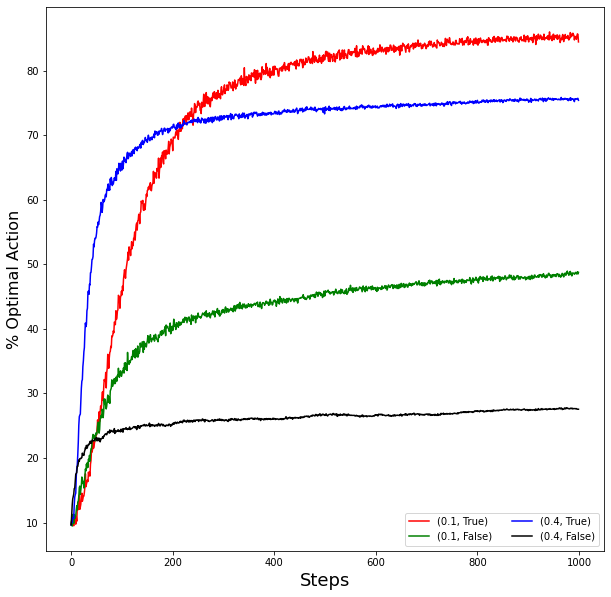

CPU times: user 142 ms, sys: 11.3 ms, total: 153 ms
Wall time: 2min 5s


In [10]:
%%time
with multiprocessing.Manager() as manager:
    global_reward_list = []
    mp_objects = []
    apply_baseline = [True, False,True,False] 
    stepSize_list    = [0.1, 0.1, 0.4, 0.4]
    color_list      = ['r', 'g', 'b', 'k']
    
    for index,step_size in enumerate(stepSize_list):
        global_reward_list.append(manager.list())
        mp_objects.append(multiprocessing.Process(target=gradient_bandit,
                                                  args=(steps, n_bandit, n_lever,
                                                        step_size,apply_baseline[index],
                                                        testbed, initial_reward_estimates,
                                                        global_reward_list[len(global_reward_list)-1])) )
    for index in range(len(mp_objects)):
        mp_objects[index].start()

    for index in range(len(mp_objects)):
        mp_objects[index].join()
        
    plt.figure(figsize=(10,10))
    plt.xlabel('Steps', fontsize=18)
    plt.ylabel('% Optimal Action', fontsize=16)
    for  index in range(len(mp_objects)):
        plt.plot(np.arange(steps),global_reward_list[index][0],label=(stepSize_list[index],apply_baseline[index]), color=color_list[index])
    
    plt.legend(loc='lower right', ncol=2)
    
    plt.show()